<a href="https://colab.research.google.com/github/colinx0/EmoteCNN/blob/main/Emote_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch torchvision matplotlib tqdm scikit-learn opencv-python

In [ ]:
dimport torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
from sklearn.metrics import accuracy_score

class EmotionCNN(nn.Module):
    def __init__(self, num_classes=7):
        super(EmotionCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.drop1 = nn.Dropout(0.25)

        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv4 = nn.Conv2d(128, 128, 3, padding=1)
        self.drop2 = nn.Dropout(0.25)

        self.fc1 = nn.Linear(128 * 6 * 6, 256)
        self.fc2 = nn.Linear(256, num_classes)
        self.drop3 = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.drop1(x)
        x = F.relu(self.conv3(x))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.drop2(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.drop3(x)
        x = self.fc2(x)
        return x

def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    for imgs, labels in tqdm(dataloader, desc="Training", leave=False):
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        out = model(imgs)
        loss = criterion(out, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * imgs.size(0)
    return total_loss / len(dataloader.dataset)

def evaluate(model, dataloader, device):
    model.eval()
    preds, targets = [], []
    with torch.no_grad():
        for imgs, labels in tqdm(dataloader, desc="Evaluating", leave=False):
            imgs = imgs.to(device)
            out = model(imgs)
            preds.extend(out.argmax(1).cpu().numpy())
            targets.extend(labels.numpy())
    return accuracy_score(targets, preds)

In [ ]:
import os
import pandas as pd
import numpy as np
import cv2
from google.colab import drive

# ==============================
# MOUNT DRIVE
# ==============================
drive.mount('/content/drive')

# Path to where fer2013.csv is located
csv_path = "/content/drive/MyDrive/fer2013/fer2013.csv"
output_dir = "/content/drive/MyDrive/fer2013/data"

if os.path.exists(output_dir):
  raise SystemExit

# ==============================
# CREATE FOLDERS
# ==============================
emotion_labels = {
    0: "angry",
    1: "disgust",
    2: "fear",
    3: "happy",
    4: "sad",
    5: "surprise",
    6: "neutral"
}

for split in ["Training", "PublicTest", "PrivateTest"]:
    for emotion in emotion_labels.values():
        os.makedirs(os.path.join(output_dir, split, emotion), exist_ok=True)

# ==============================
# CONVERT CSV TO IMAGES
# ==============================
df = pd.read_csv(csv_path)
print(f"Loaded {len(df)} entries")

for i, row in df.iterrows():
    pixels = np.fromstring(row["pixels"], sep=" ")
    image = pixels.reshape(48, 48)
    emotion = emotion_labels[row["emotion"]]
    usage = row["Usage"]

    folder = os.path.join(output_dir, usage, emotion)
    file_path = os.path.join(folder, f"{i}.png")
    cv2.imwrite(file_path, image)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


SystemExit: 

Epoch 1/10 | Loss: 1.7361 | Val Acc: 0.390


Epoch 2/10 | Loss: 1.5267 | Val Acc: 0.463


Epoch 3/10 | Loss: 1.3999 | Val Acc: 0.505


Epoch 4/10 | Loss: 1.3165 | Val Acc: 0.519


Epoch 5/10 | Loss: 1.2633 | Val Acc: 0.545


Epoch 6/10 | Loss: 1.2120 | Val Acc: 0.542


Epoch 7/10 | Loss: 1.1736 | Val Acc: 0.559


Epoch 8/10 | Loss: 1.1360 | Val Acc: 0.568


Epoch 9/10 | Loss: 1.1029 | Val Acc: 0.574


Epoch 10/10 | Loss: 1.0674 | Val Acc: 0.576


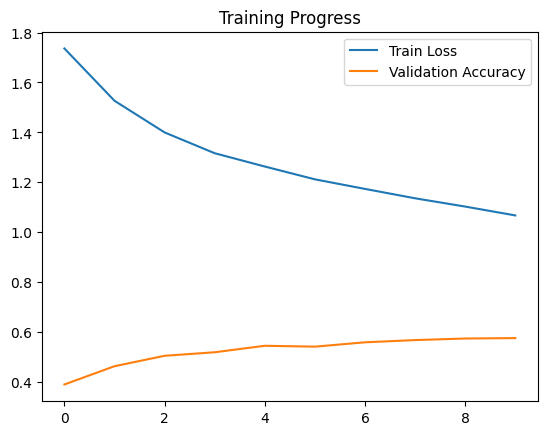

Model saved as emotion_cnn.pth


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

# ==============================
# CONFIG
# ==============================
DATA_DIR = "/content/drive/MyDrive/fer2013/data/Training"
BATCH_SIZE = 64
EPOCHS = 10
LR = 0.001
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# ==============================
# DATA
# ==============================
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = datasets.ImageFolder(root=DATA_DIR, transform=transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE)

# ==============================
# MODEL
# ==============================
model = EmotionCNN(num_classes=len(dataset.classes)).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

# ==============================
# TRAINING LOOP
# ==============================
train_losses, val_accs = [], []

for epoch in range(EPOCHS):
    loss = train_one_epoch(model, train_loader, criterion, optimizer, DEVICE)
    acc = evaluate(model, val_loader, DEVICE)
    train_losses.append(loss)
    val_accs.append(acc)
    print(f"Epoch {epoch+1}/{EPOCHS} | Loss: {loss:.4f} | Val Acc: {acc:.3f}")

# ==============================
# VISUALIZE RESULTS
# ==============================
plt.figure()
plt.plot(train_losses, label='Train Loss')
plt.plot(val_accs, label='Validation Accuracy')
plt.legend()
plt.title("Training Progress")
plt.show()

# ==============================
# SAVE MODEL
# ==============================
torch.save(model.state_dict(), "emotion_cnn.pth")
print("Model saved as emotion_cnn.pth")

In [ ]:
!ls /content/drive/MyDrive/fer2013/data

PrivateTest  PublicTest  Training


In [ ]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found
